# Détection d'instants
Quand on dispose d'un signal temporel on cherche souvent à en analyser une partie. Pour cela il faut détecter un instant particulier ou délimiter des bornes (deux instants). A chaque fois qu'un instant doit être choisi, les analystes développent un code spécifique qui a toutes les chances d'être difficile à maintenir car des éléments inattendus peuvent survenir avec l'arrivée de nouveaux signaux.

Hors dans la majorité des cas l'instant qui intéresse un expert est clairement visible sur l'un des signaux temporels univarié, éventuellement la conjonction de deux signaux, mais rarement plus. Par ailleurs, sur le signal en question cet instant est facilement identifiable : il est proche d'une bosse ou d'un creu et en fonction de l'échelle d'observation on doit facilement le détecter puisque c'est un élément essentiellement visuel.

Ce module utilise un Opset en entrée, construit une interface permettant l'identification graphique par un expert de l'instant choisi sur quelques signaux.
Ensuite un algorithme fabrique des indicateurs basés sur la détection de creux et de bosses et extrait des points au hasard sur les courbes visualisées par l'expert. Chacun de ces points est un vecteur de grande dimension dont les coordonnées correspondent à des indicateurs de position (numéro et position des creux et bosses) à différentes échelles.
L'algorithme essaye de détecter si les points tirés sont à gauche (-1) ou à droite (+1) de l'instant sélectionné.

Finalement un indicateur d'estimation de présence de l'instant est construit et une détection est faite avec plus ou moins de confiance.

L'expert peut tester son détecteur et éventuellement le corriger en ajoutant des identifications manuelles et en relançant l'apprentissage. 

In [1]:
import numpy as np
from scipy import signal
import pandas as pd
import tabata as tbt
from tabata import Opset, Selector

Pour des raisons de debuggage, je recharge le module.

In [2]:
%reload_ext autoreload
%autoreload 2

## Création du sélecteur d'instants.
On utilise les données retraitées depuis le notebook _opset_doc_. Le Selector est un Opset disposant de fonctions de sélection dans son interface.

In [3]:
fieldname = 'data/out/AFL1EB_C.h5'
S = Selector(fieldname)

On affiche les observations (comme pour Opset), mais la différence est dans l'utilisation du clic de souris. En cliquant sur la courbe on peut sélectionner un instant.

In [4]:
S.plot(name="ALT")

Un onglet "Param" offre une interface de paramétrage de l'apprentissage. Les caractéristiques de ces paramètres sont décrits plus bas.

L'onglet "Learn" a un bouton qui permet de lancer ou relancer un apprentissage.
Il est rouge parce que l'on a pas encore montré à l'algorithme quels sont les instants à identifier. Dès que l'on aura cliqué sur un point de la courbe une barre verticale mettra en évidence cet instant et le bouton passera ua bleu pour montrer que l'on peut déjà lancer un apprentissage. La liste à gauche du bouton correspond aux variables que peut sélectionner l'expert. Par défaut encore aucune variable n'est sélectionnée, mais dès qu'une courbe sera identifiée par une sélection d'instant, une variable sera choisie. L'expert peut modifier à tout instant cette sélection avant de lancer son apprentissage. Attention cependant, si aucune variable n'est sélectionnée l'algorithme ne peut utiliser que la position et la position relative des points sur les courbes.

Les points selectionnés sont stockés dans la variable `selected` et les signaux observés sont dans `viewed` et les variables visualisées dans `variables`. On a cette seconde variable car un expert qui voit un signal mais ne sélectionne pas d'instant donne une information qu'il est aussi possible d'exploiter.

Certains environnements comme "Google Collab" ne gèrent pas les `FigureWidgets` de Plotly ce qui empèche de cliquer sur un point de la courbe. C'est pourquoi une version légèrement dégradée est proposée avec la méthode `.plotc()`.

In [5]:
S.plotc()

Comme on ne peut plus cliquer sur la courbe, une barre horizontalle a été rajoutée, elle permet de sélectionner un point. Par contre pour annuler une sélection précédente, il faut penser à ramener la valeur de ce point à 0.

In [6]:
print('Instants selectionnés :\n', S.selected)
print('Signaux observés :\n', S.viewed)

Instants selectionnés :
 {}
Signaux observés :
 {0}


Pour des raisons de test nous supposerons que les instants et observations ont été sauvegardées.

In [7]:
S.selected = \
{0: 1960, 1: 1821, 3: 1732, 4: 1600, 5: 1391, 6: 1736, 
 7: 1615, 16: 2362, 18: 2622}

S.viewed = {0, 1, 3, 4, 5, 6, 7, 16, 18}

S.variables = {'ALT[m]'}

Pour les instants, la sauvegarde est un dictionnaire indexé par le numéro d'enregistrement (signal) avec pour valeur la position de l'instant choisi.

## Création des indicateurs.
Les indicateurs sont des compteurs de bosses et de creux. Une bosse ou un creu est détecté par le passage par zéro de la dérivée du signal. On utilise des échelles différentes pour lisser le signal et on regardera en plus des bosses et des creux les points d'inflexion qui sont les bosses et creux de la dérivée.

L'algorithme de lissage employé est un filtre de Savitsky-Golay : un filtre polynômial que l'on utilise avec des polynômes de degré 2. On fixe une largeur de filtre et sur chaque fenêtre on essaye d'estimer la courbe par une parabole, le résultat du filtre est la valeur au centre de la fenêtre. L'utilisation d'un polynôme de degré deux évite la surparamétrisation et autorise le calcul des dérivées d'ordre 1 et 2.

In [8]:
len(S)

48

In [9]:
dsi = S.make_indicators()

La méthode `make indicator()` renvoie un nouveau Selector qui a ses propriétés `selected` et `viewed` vides, mais pas sa propriété `computed`. Cette dernière affiche les points sélectionnés précédemment par des traits pointillés en bleu. Ils ne sont pas modifiable contrairement aux sélections violettes.

In [10]:
dsi.plot()

En parcourant cet Opset, vous remarquerez que seules les opérations sélectionnées sont enregistrées. (On utilise ici un selector plutot qu'un Opset pour pouvoir visualiser les positions. Bien entendu un apprentissage n'a pas de sens sur ces données.)

D'autre part, en regardant la liste des variables on voit des noms un peu originaux :

* LEN correspond à la position absolue dans le signal ;
* REV est la position absolue inverse ;
* PERCENT est la position relative par rapport à la longuer du signal.

Les unités _pts_ et _%_ représentent le numéro de point et le pourcentage.

Les autres variables sont toutes de noms correspondants à la variable originale sélectionnée et l'unité ce code ainsi : _w#o#u#_ ou _w#o#d#_.

* _w_ correspond à la demi-largeur du filtre ;
* _o_ est l'ordre de dérivation (1 ou 2) ;
* _u_ et _d_ représentent un passage par zéro en montant (up) ou en descendant (down).

Ces valeurs sont issues du paramétrage par défaut de la méthode :

     def make_indicators(self, filename=None):
                        
Le nom du fichier par défaut sera le même que celui du Selector (même répertoire) avec le préfixe '_I'.

Cette fonction utilise des paramètres stockés dans un dictionnaire `features_params`.

In [11]:
S.feature_params

{'range_width': range(35, 351, 35),
 'range_sigma': range(5, 26, 10),
 'max_order': 2}

* `range_width` est un itérateur donnant les demi-largeurs qui correspond par défaut aux dix premiers centièmes de la longueur du plus petit signal (10 étant la plus petite valeur acceptable). Pour un signal de 1000 points on obtient `range(10,101,10)`.
* `range_sigma` est un itérateur des seuil permettant de détecter les passages par zéro, ce sont des multiples de l'écart-type local du signal lissé. Si le seuil est positif or regarde les passage par zéro en montant et s'il est négatif, les passages par zéro en descendant. Par défaut on prend `range(5,26,10)` et son opposé soit -25 -15 -5 5 15 25.
* `max_order` est l'ordre maximal de dérivation. Le degré du polynome estimé est égal à 2 par défaut sauf si on recherche des indicateurs d'ordre plus élevé, auquel cas le degré du polynome sera aussi augmenté.

## Apprentissage
L'apprentissage peut être lancé directement depuis l'affichage.

In [12]:
S.plot()

Remarquez que le boutton est passé au bleu parce qu'il existe désormais des signaux qui ont été labellisés. On peut appuyer sur ce bouton ou appeler la méthode `fit()`.

In [13]:
S.fit()

First keeping 15 indicators over 244
Then  keeping 3 indicators over 244


OPSET 'data/out/AFL1EB_C.h5' de 48 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None
INSTANTS : 9 instant(s) sélectionnés parmis 9 courbes observées et 1 variables.

L'apprentissage utilise des arbres de décision. Dans un premier temps on recherche par une génération aléatoire d'un nombre d'arbres donnés (10 par défaut) quelles sont les indicateurs (features) les plus importantes. On extrait ces indicateurs puis on recommence des apprentissages d'arbre de décision en ne concervat à la fin que les indicateurs utiles. Ceux-ci sont mémorisés dans la variable `idcodes`.

In [14]:
S.idcodes

[('ALT[m]', 140, 1, -5, 0.007815965348088028),
 ('ALT[m]', 175, 0, 15, 0.16862963380911355),
 ('ALT[m]', 350, 1, -5, 0.004065430919702637)]

Chaque élément de cette liste est un 5-uplet :
* Le nom de la courbe traitée.
* La demi-largeur du filtre.
* L'ordre de dérivation moins 1 (0 est une dérivée, 1 est un laplacien).
* Le nombre d'écart-types pour le seuil de détection (positif par le haut et négatif par le bas).
* La valeur de l'écart-type conservée pour cette analyse.

L'interprétation des règles peut être obtenue par l'appel à la méthode `describe()`.

In [15]:
S.describe()

           Name  Filter  Order  Sigma       Std
Feature                                        
0        ALT[m]     140      1     -5  0.007816
1        ALT[m]     175      0     15  0.168630
2        ALT[m]     350      1     -5  0.004065
|--- feature_1 <= 2.00
|   |--- feature_0 <= 3.81
|   |   |--- feature_1 <= 2.00
|   |   |   |--- feature_1 <= 1.99
|   |   |   |   |--- class: -1
|   |   |   |--- feature_1 >  1.99
|   |   |   |   |--- class: -1
|   |   |--- feature_1 >  2.00
|   |   |   |--- class: -1
|   |--- feature_0 >  3.81
|   |   |--- class: 1
|--- feature_1 >  2.00
|   |--- feature_0 <= 0.38
|   |   |--- class: -1
|   |--- feature_0 >  0.38
|   |   |--- feature_2 <= 0.34
|   |   |   |--- class: -1
|   |   |--- feature_2 >  0.34
|   |   |   |--- class: 1



In [16]:
S.plot()

Un nouvel affichage montre qu'une détection a été faite. Un trait pointillé bleu se superpose au choix de l'utilisateur (rouge). La courbe en bas représente l'estimation de présence.

Le bouton est passé au vert pour montrer que tout s'est bien passé. On peut continuer à sélectionner des instants et relancer l'apprentissage.

Si on avance dans l'Opset on peut observer des détections sur des observations que l'on avait pas regardé.

In [17]:
S.plot(pos=8)

La barre de défilement "Filter" permet de modifier la taille du filtre de prédiction. Pour cet exemple simple vous verrez en la modifiant que cela ne change pas grand chose. Cependant dans des cas plus complexes, il peut y avoir un niveau de doute plus important et cela peut être intéressant de visualiser celui-ci. Le paramètre de lissage est stocké dans le dictionnaire `predict_params`.

In [18]:
S.predict_params

{'filter_width': 100}

Les paramètres d'apprentissage sont stockés dans le dictionnaire `learn_params`.

In [19]:
S.learn_params

{'retry_number': 10,
 'retry_percentile': 80,
 'samples_percent': 0.01,
 'min_samples_split': 0.05}

* `retry_number` est le nombre d'arbres aléatoires fabriqués pour la recherche des indicateurs pertinents.
* `retry_percentile` est un quantile sur la fréquence minimale pour laquelle l'indicateur doit être obnservé pour être retenu.
* `samples_percent` est le pourcentage de points extrait des courbes pour l'apprentissage de chaque arbre.
* `min_sample_split` est le taux minimal d'observations en dessous duquel les arbres ne se développeront plus.

Les paramètres pour les indicateurs et l'apprentissage peuvent être modifiés graphiquement depuis une petite interface spécialisée.

In [20]:
S.param()

## Prédictions

La fonction `belief(df)` renvoit l'estimateur de position pour le DataFrame courant ou un DataFrame externe. Si le DataFrame est issu de la position courante alors la détection sera calculée et le dictionnaire `computed` mis à jour.

On construit une liste de données différente de la première pour simuler un jeu de test sachant que l'on a appris les instants que sur les premières observations.

In [21]:
teststore = "data/out/AFL1EB_CT.h5"
ST = Opset(teststore)
ST.clean() # Au cas où le fichier existerait déjà.

for df in S[-10:]:
    ST.put(df)

In [22]:
ST.records

['/record_42',
 '/record_43',
 '/record_44',
 '/record_45',
 '/record_46',
 '/record_47',
 '/record_48',
 '/record_49',
 '/record_50',
 '/record_51']

Affichons le score du troisième individu. 

In [23]:
import plotly.graph_objects as go
import plotly.express as px
#from plotly.offline import init_notebook_mode, iplot
#import plotly.io as pio

#pio.renderers.default = "vscode"
df = ST[1]
p = S.belief(df)
mx = np.argmax(p)
print("Maximum for point", mx, "at", df.index[mx])
px.line(x=df.index,y=p*100,
        height=300,
        title="Prédiction de l'instant",
        labels={'x':'date', 'y':'%'}
       )

Maximum for point 2274 at 2013-02-14 11:19:54


Maximum for point 2274 at 2013-02-14 11:19:54


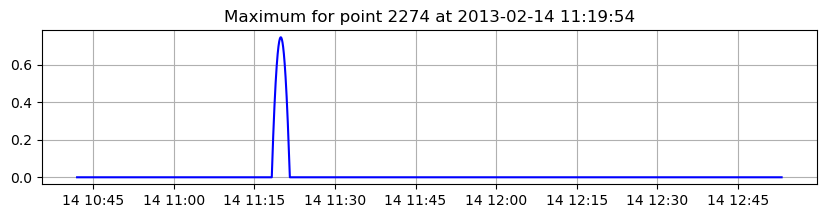

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

df = ST[1]
p = S.belief(df)
mx = np.argmax(p)
print("Maximum for point", mx, "at", df.index[mx])
plt.figure(figsize=(10,2))
plt.plot(df.index,p*100,'b-')
plt.grid()
plt.title(f"Maximum for point {mx} at {df.index[mx]}") ;

La prédiction globale pour tout le fichier s'obtient facilement à l'aide de la méthode `predict()`. Le retour correspond à la variable `computed` ce qui permet de visualiser toutes les prédictions sans avoir à les recalculer.

In [25]:
r = S.predict()
print("Instant signal", S.records[8], "#", 8, "on", r[8], "at", S[8].index[r[8]])

Instant signal /record_12 # 8 on 2446 at 2013-01-29 04:38:46


Pour prédire sur tout un fichier il suffit de le passer en argument. On peut aussi passer un Opset ce qui rend les manipulations plus pratiques.

In [26]:
r = S.predict(ST)
print("Instant signal", ST.records[8], "#", 8, "on", r[8], "at", ST[8].index[r[8]])

Instant signal /record_50 # 8 on 1714 at 2013-02-19 22:58:34


In [27]:
for i in r:
    print(i,r[i],ST.records[i],ST[i].index[r[i]])

0 9098 /record_42 2013-02-14 08:45:38
1 2274 /record_43 2013-02-14 11:19:54
2 1497 /record_44 2013-02-14 14:00:57
3 2094 /record_45 2013-02-14 21:39:54
4 2111 /record_46 2013-02-15 00:37:11
5 2478 /record_47 2013-02-17 00:02:18
6 2138 /record_48 2013-02-19 10:14:38
7 2916 /record_49 2013-02-19 14:13:36
8 1714 /record_50 2013-02-19 22:58:34
9 2196 /record_51 2013-02-20 03:34:36


On peut ausi directement passer le nom du fichier.

In [28]:
r = S.predict(teststore)
print("Instant signal", ST.records[8], "#", 8, "on", r[8], "at", S[8].index[r[8]])

Instant signal /record_50 # 8 on 1714 at 2013-01-29 04:26:34


Les écarts entre prédictions et labels sont obtenus automatiquement par la méthode `all_scores()`. La méthode `score()` sans arguments renvoie la max des valeurs absolues des écarts.

In [29]:
S.all_scores()

{0: -19, 1: 2, 3: 25, 4: 8, 5: -5, 6: -16, 7: 12, 16: 16, 18: 10}

Finalement on peut directement avoir le maximum des valeurs absolues des scores.

In [30]:
S.score()

25

## Changement de fichier

Il est aussi possible de recharger un nouveau fichier dans le Selector.

In [31]:
S.load('data/out/AFL1EB_CT.h5')

OPSET 'data/out/AFL1EB_CT.h5' de 10 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None
INSTANTS : 0 instant(s) sélectionnés parmis 0 courbes observées et 0 variables.

In [32]:
S.plot()

Cette manipulation simple permet de garder le prédicteur tout en remettant l'ensemble des sauvegardes à zéro. C'est une manière facile d'accéder aux résultats de prédiction sans les recalculer immédiatement.

## Découpage
Finalement on va découper le signal en fonction de l'instant calculé : les deux méthodes `left()` et `right()` extraient les parties respectives du signal et produisent chacune un `Selector`. Il est possible de passer un nom de fichier pour le stockage du bout de signal extrait ou on laisse le système ajouter la lettre 'L' ou 'R' à la fin du nom du fichier original.

In [33]:
L = S.left()
L.plot()

L'intérêt de produire un `Selector` plutôt qu'un Opset et de permettre la récurence des détections d'instants.

On peut aussi utiliser deux détecteurs d'instants pour extraire le signal intermédiaire par la méthode `between(left,right)` où les deux paramètres peuvent être soit des `Selector`soit des dictionnaires d'instants issu du même fichier HDF5 original.

In [34]:
# Détection de fin de croisière.
S1 = Selector(S)
S1.selected = {0: 5559, 1: 5088, 2: 5217, 3: 3825, 11: 5169, 10: 5877, 47: 7185, 4: 2346, 6: 2132, 7: 4967, 8: 4803, 9: 4775, 19: 6780, 18: 6922, 16: 4941, 31: 4886}
S1.variables = {'ALT[m]'}
S1.viewed = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47}
S1.fit()

First keeping 19 indicators over 244
Then  keeping 6 indicators over 244


OPSET 'data/out/AFL1EB_C.h5' de 48 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None
INSTANTS : 16 instant(s) sélectionnés parmis 48 courbes observées et 1 variables.

On calcule les sélections gauche et droite puis on extrait l'intervalle entre les deux.
Pour bien faire, il faudrait s'assurer que les sélections sont compatibles entre elles et avec la liste d'opération.

In [35]:
L = S.predict()
R = S1.predict()
B = S.between(L,R)

In [36]:
B.plot()

Cette fois on produit un Opset car il ne sert à rien d'itérer sur des sous-instants.

## Sauvegarde
Pour pouvoir retravailler sur cette sélection d'instants on les sauvegarde dans un pickle.

In [37]:
import pickle
with open('data/out/interval.pkl','wb') as pkl:
    pickle.dump((S,S1),pkl)

In [38]:
for df in B:
    print(df.index.name,len(df))

record_00 3619
record_01 3285
record_02 3080
record_03 2150
record_04 730
record_05 423
record_10 410
record_11 3395
record_12 2396
record_13 2719
record_14 3801
record_15 3614
record_16 3354
record_17 2712
record_18 3958
record_19 3321
record_20 2552
record_21 1538
record_22 4293
record_23 5020
record_24 3959
record_25 2446
record_26 3909
record_27 2981
record_28 1328
record_29 2326
record_30 542
record_31 842
record_32 7499
record_33 6425
record_34 3018
record_35 2905
record_36 5228
record_37 5183
record_38 2625
record_39 3660
record_40 4492
record_41 4705
record_42 0
record_43 3730
record_44 2608
record_45 3115
record_46 3516
record_47 4049
record_48 5865
record_49 5924
record_50 617
record_51 4984


_Jérôme Lacaille (YOR)_